# Прогнозирование заказов такси

## Описание данных

**`num_orders`** - количество заказчиков

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [2]:
pth1 = 'datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'


if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=['datetime'], parse_dates=True)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=['datetime'], parse_dates=True)    
else:
    print('Something is wrong')

In [3]:
df.head()

## Исследование и анализ данных

In [4]:
df.info()

У нас есть данные о количестве заказов такси с 01.03.2018 по 31.08.2018. 26496 строк без пропусков.

In [5]:
df.describe()

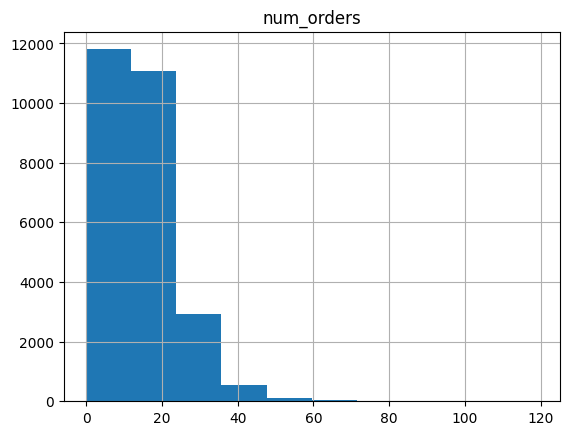

In [6]:
df.hist()

In [7]:
df.index.is_monotonic_increasing

Отдельно изучим ресемлированный фрейм по дням.

In [8]:
df_day = df.resample('1D').sum()

А также сохраним ресемплирование по часам.

In [9]:
df = df.resample('1H').sum()

In [10]:
df.head()

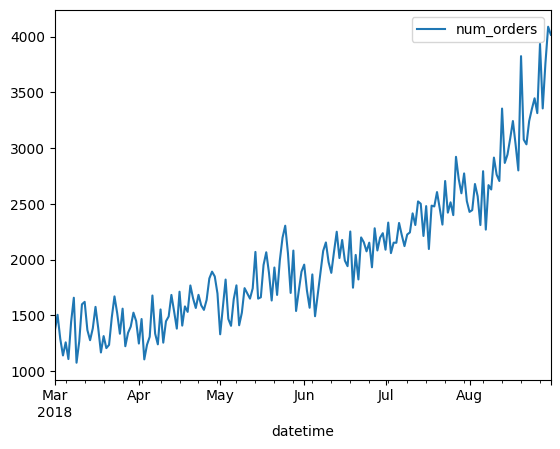

In [11]:
df_day.plot()

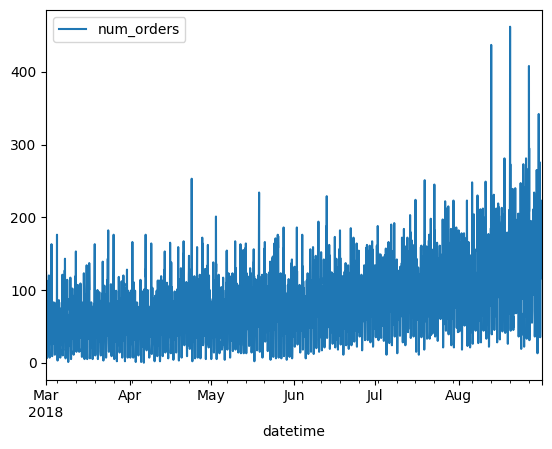

In [12]:
df.plot()

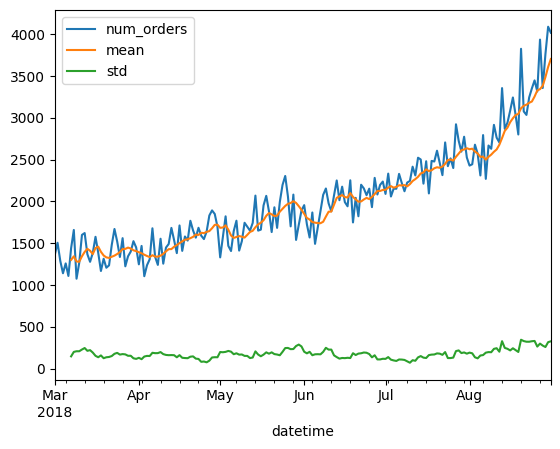

In [13]:
# распределения скользящих среднего и ст. отклонения по неделям
df_day['mean'] = df_day['num_orders'].rolling(7).mean()
df_day['std'] = df_day['num_orders'].rolling(7).std()
df_day.plot()

Разложим наш ряд на тренд и сезонность.

In [14]:
decomposed_hour = seasonal_decompose(df['num_orders'], model='additive')

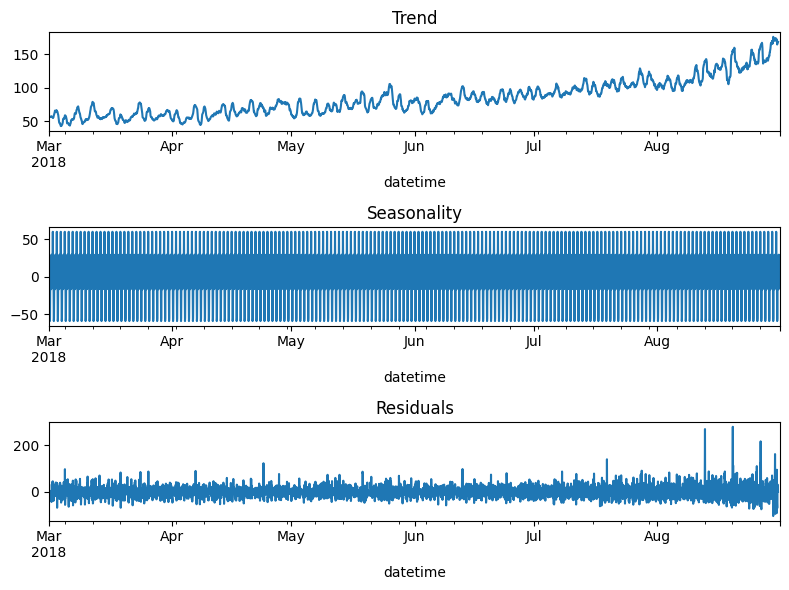

In [15]:
plt.figure(figsize=(8, 6))

ax = plt.subplot(311)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Trend')

ax = plt.subplot(312)
decomposed_hour.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

ax = plt.subplot(313)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Тренд прослеживается хорошо, но вот с сезонностью - не очень понятно, нам нужно посмотреть на более укрупненные данные. Поэтому посмотрим разложение ряда с ресемплированием в 1 день.

In [16]:
decomposed_day = seasonal_decompose(df_day['num_orders'], model='additive')

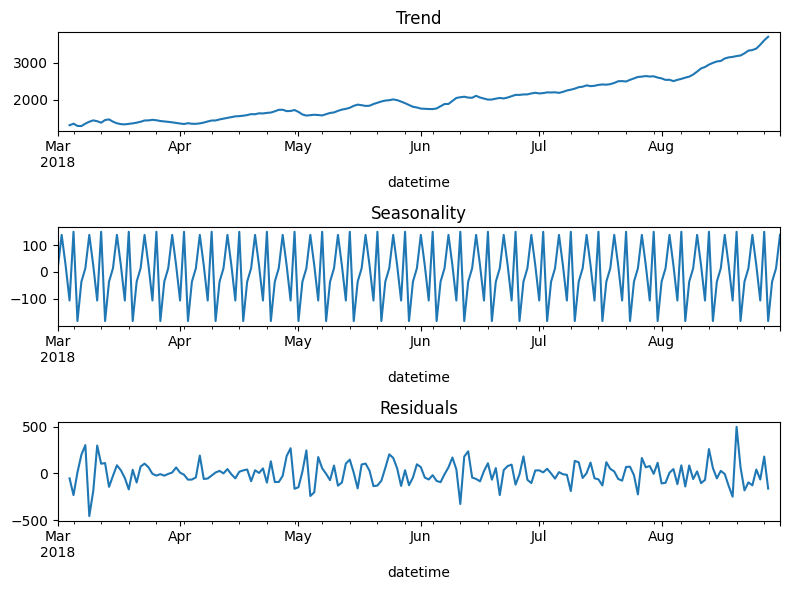

In [17]:
plt.figure(figsize=(8, 6))

ax = plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')

ax = plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

ax = plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Четко прослеживается тренд на постепенное увеличения числа заказов со временем.  
Сезонность по неделям - 2 пика в неделю. 

Возьмем данные за неделю c 02.07 по 08.07 (с пн по вс) и также посмотрим разложение.

In [18]:
df_week = df['2018-07-02':'2018-07-08']

In [19]:
decomposed_hour = seasonal_decompose(df_week['num_orders'])

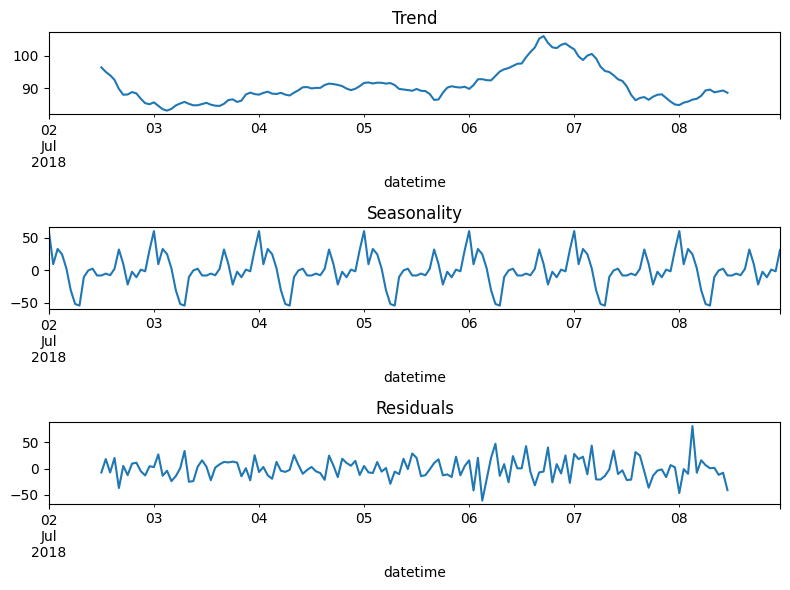

In [20]:
plt.figure(figsize=(8, 6))

ax = plt.subplot(311)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Trend')

ax = plt.subplot(312)
decomposed_hour.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

ax = plt.subplot(313)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Тренд нам показывает увеличение заказов к субботе.  
Сезонность по времени суток - пик в 00.00 и вечернее время.

Проверим на стационарность ресемплированный по часу ряд - с помощью теста Дики-Фуллера.  
Н0: Временной ряд является нестационарным. Т.е., он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.  
Н1: Временной ряд является стационарным.

In [21]:
alpha = 0.05
p_value = adfuller(df['num_orders'], autolag='AIC')[1]
print('P value: ', p_value)

if p_value < alpha:
    print('P value < alpha, отвергаем Н0, ряд стационарен')
else:
    print('P value > alpha, не можем отвергнуть Н0, ряд нестационарен')


### Вывод

1. Данные ресемплировали по часу.
2. Распределение скользящего среднего по неделям - постепенно растет. Ст.отклонение при этом остается примерно на одном уровне.
3. Есть тренд на постепенное увеличение заказов со временем.  
4. Есть сезонность сезонность по неделям - с пиком заказов в субботу, а также сезонность по суткам - пик в 00 часов и вечернее время. 
5. Проверили стационарность ряда (ресемплированного по 1 часу) на тесте Дики-Фуллера - нащ ряд стационарен.

## Создание признаков

In [22]:
len(df)

После ресемплирования у нас осталось 4416 объектов.

### Календарные признаки

In [23]:
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour
df.head()

### Отстающие значения

Создадим функцию для создания признаков - отстающих значений.

In [24]:
def make_lag(data, max_lag):
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [25]:
make_lag(df, 18)

### Скользящее среднее

In [26]:
df['rolling_mean'] = df['num_orders'].shift().rolling(6).mean()

In [27]:
df.head()

Удалим строки с пропусками, которые появились из-за отстающих значений.

In [28]:
df = df.dropna()

In [29]:
df.info()

### Вывод

1. Добавили 4 календарных признака, 18 отстающих и 1 - скользящее среднее.
2. Удалили строки с пустыми значениями, которые получились из-за отстающих признаков.
3. Итого у нас получился фрейм размером 4398 * 24 (один признак целевой).

## Подготовка данных к обучению

In [30]:
RANDOM_STATE = 100500

In [31]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [33]:
tscv = TimeSeriesSplit(n_splits=4, test_size=400)

In [34]:
def rmse(target, predict):
    rmse = np.sqrt(mean_squared_error(target, predict))
    return rmse

In [35]:
scorer = make_scorer(rmse, greater_is_better=False)

### Вывод

1. Отделили 10% объектов для теста.
2. Использовали TimeSeriesSplit для разделения на фолды по времени - для дальнейшего поиска оптимальных гиперпараметров с помощью GridSearchCV.
3. Создали функцию и scorer для расчета RMSE.

## Обучение моделей

### Catboost

In [36]:
cat = CatBoostRegressor(iterations=500, early_stopping_rounds=12, random_state=RANDOM_STATE)

In [37]:
cat_params = {'depth': [6,8,10], 
              'learning_rate' : [0.05, 0.1, 0.2], 
              'l2_leaf_reg': [2, 3, 4]}

In [38]:
cat_search = GridSearchCV(cat, cat_params, cv=tscv, scoring=scorer)

In [39]:
%%time
cat_search.fit(X_train, y_train, verbose=False)

In [40]:
-cat_search.best_score_

In [41]:
cat_search.best_params_

In [42]:
cat_search.scorer_

### LightGBM

In [43]:
gbm = LGBMRegressor(n_estimators=500, random_state=RANDOM_STATE)

In [44]:
gbm_params = {
    'num_leaves': [70, 150, 210],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [-1, 10, 15, 20]
}

In [45]:
gbm_search = GridSearchCV(gbm, gbm_params, cv=tscv, scoring=scorer)

In [46]:
%%time
gbm_search.fit(X_train, y_train, verbose=False)

In [47]:
-gbm_search.best_score_

In [48]:
gbm_search.best_params_

### LogisticRegression

In [49]:
scaler = StandardScaler()
pca = PCA()

In [50]:
logreg = LogisticRegression(penalty='l2', max_iter=100, random_state=RANDOM_STATE)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ('logreg', logreg)])

n_components = list(range(1, X_train.shape[1]+1,2))
C = [0.1, 1, 10]
solver = ['lbfgs', 'liblinear', 'sag']

parameters = dict(pca__n_components=n_components,
                      logreg__C=C,
                     logreg__solver=solver)


In [51]:
logreg_search = GridSearchCV(pipe, parameters, cv=tscv, scoring=scorer, n_jobs=-1)

In [52]:
%%time
logreg_search.fit(X_train, y_train)

In [53]:
-logreg_search.best_score_

In [54]:
logreg_search.best_params_

### Сравнение моделей

In [55]:
comparison = pd.DataFrame({
    'Catboost': -cat_search.best_score_,
    'LightGBM': -gbm_search.best_score_,
    'LogisticRegression': -logreg_search.best_score_
}, index=['RMSE'])
comparison.round(3)

### Вывод

`LightGBM` обогнал `Catboost` на 0.001 по RMSE и при этом показывает гораздо лучшее время 1 мин 19 сек vs 9 мин 6 сек. Логистическая регрессия на последнем месте с RMSE = 35.9.   
Лучшая модель - `LightGBM`, далее проверим ее качество на тесте.

## Проверка лучшей модели

Для проверки на адеватность спрогнозируем значения ряда предыдущим значением.

In [56]:
pred_previous = y_test.shift(fill_value=y_train.tail(1)[0])
rmse(y_test, pred_previous)

In [57]:
gbm_pred = gbm_search.best_estimator_.predict(X_test)
rmse(y_test, gbm_pred)

In [58]:
pd.DataFrame(
    {'RMSE_cv': [-gbm_search.best_score_], 
     'RMSE_test': [rmse(y_test, gbm_pred)], 
     'RMSE_previous': [rmse(y_test, pred_previous)]}, 
    index= ['LightGBM']).round()

In [59]:
gbm_pred = pd.Series(gbm_pred, index=y_test.index)

Для более понятной визуализации предсказаний - возьмем недельный период с 13.08.2018 по 20.08.2018.

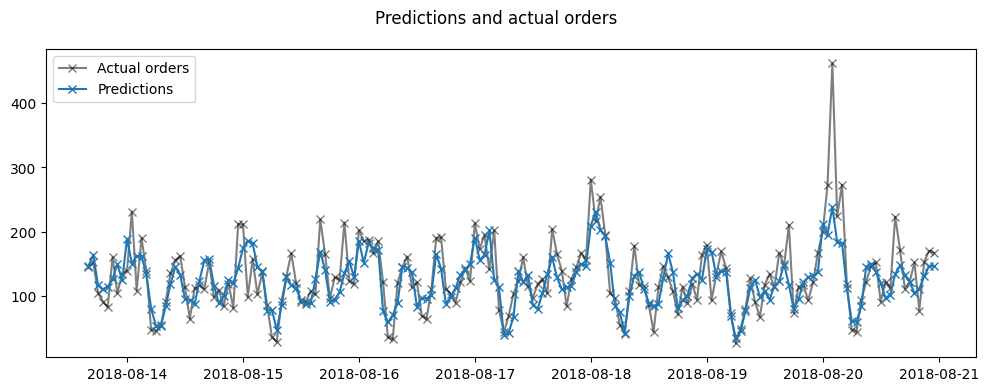

In [60]:
# график предиктов финальной модели
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions and actual orders")
ax.plot(
    y_test['2018-08-13':'2018-08-20'],
    "x-",
    alpha=0.5,
    label="Actual orders",
    color="black",
)
ax.plot(gbm_pred['2018-08-13':'2018-08-20'], "x-", label="Predictions")

_ = ax.legend()

### Вывод

    Мы обучили 3 модели: `Catboost`, `LightGBM` и `LogisticRegression` - лучший RMSE показала `LightGBM` 26.239, `Catboost` отстал всего на 0.001 по RMSE на валидации, при этом значительно уступил по времени обучения.   
    Для заказчика выбрана модель `LightGBM`.  
    На трейне она показала результат RMSE = 41 vs 59 - у модели с предыдущим предсказанием значения ряда. Модель прошла проверку на адекватность.